# Python Based K-Means Clustering

## Initial K-Means Testing on Sample Image

In [14]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import Image

width = 1920
height = 1080
new_height = int(200)
new_width = int(new_height * width / height)


print(new_height, new_width)

def main():
    

    imgpath =  "img/gradient.jpg"
#---------------------------------------------------------------------------------------------
    img = cv2.imread(imgpath, 1)
    img = cv2.resize(img, (new_width,new_height), interpolation=cv2.INTER_LINEAR)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    Z = img.reshape((-1))
    #Z = img.reshape((-1,3))
    Z = np.float32(Z)
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K=4
    ret, label1, center1 = cv2.kmeans(Z, K, None,
                                      criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    center1 = np.uint8(center1)
    res1 = center1[label1.flatten()]
    output2 = res1.reshape((img.shape))
#--------------------------------------------------------------------------------------------    
    cv2.imwrite('Outputs/gradientOutput.jpg', output2)
  
if __name__ == "__main__":
    startTime = time.time()
    main()
    finishTime = time.time()
    print("Execution time to process image: ", finishTime-startTime) #(finishTime-startTime)/(10**9))  
    Image("img/gradient.jpg")
    Image("Outputs/gradientOutput.jpg")

200 355
Execution time to process image:  1.3385562896728516


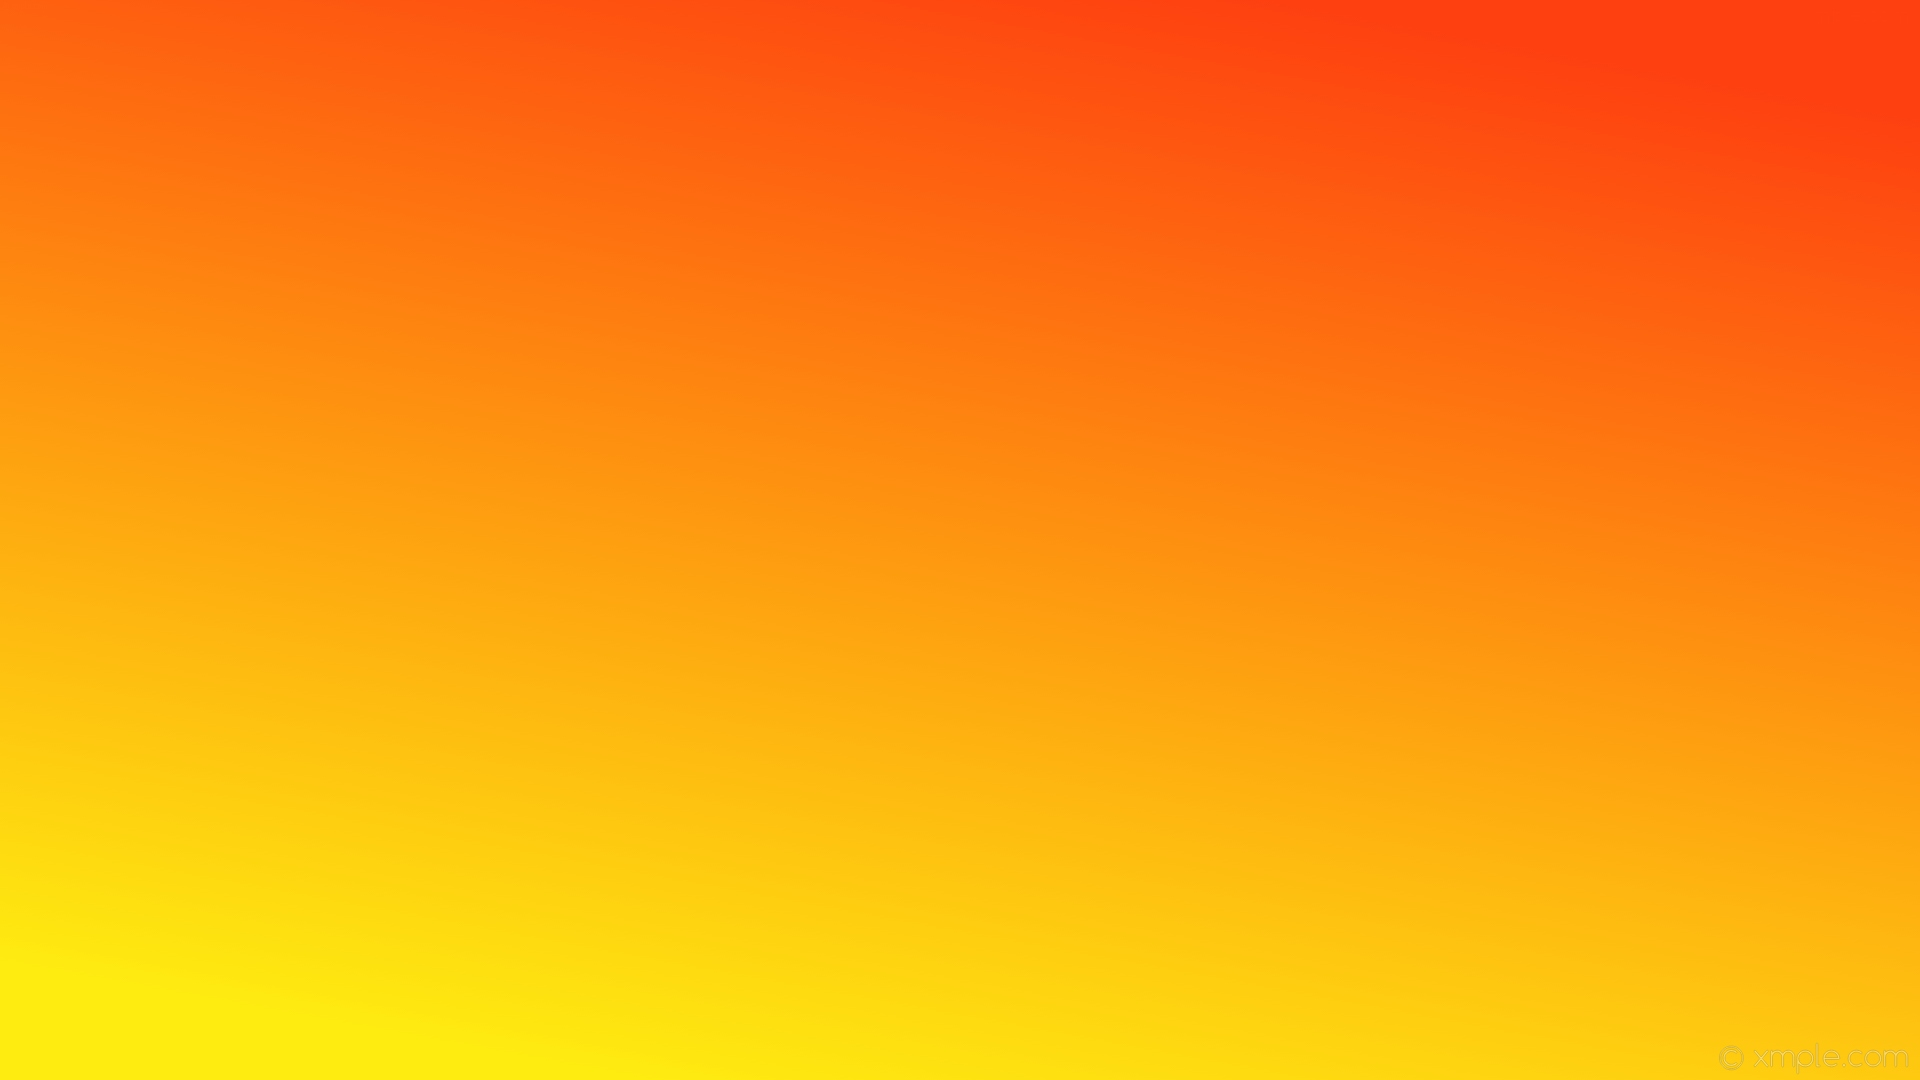

In [18]:
from IPython.display import Image
Image("img/gradient.jpg")

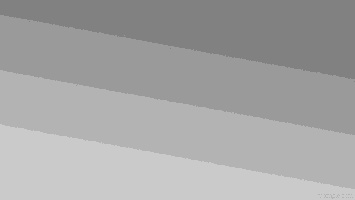

In [19]:
Image("Outputs/gradientOutput.jpg")

# Video Capture Method

## HDMI-IN

Frames per second:  32.65499966969767
Default colourspace = BGR


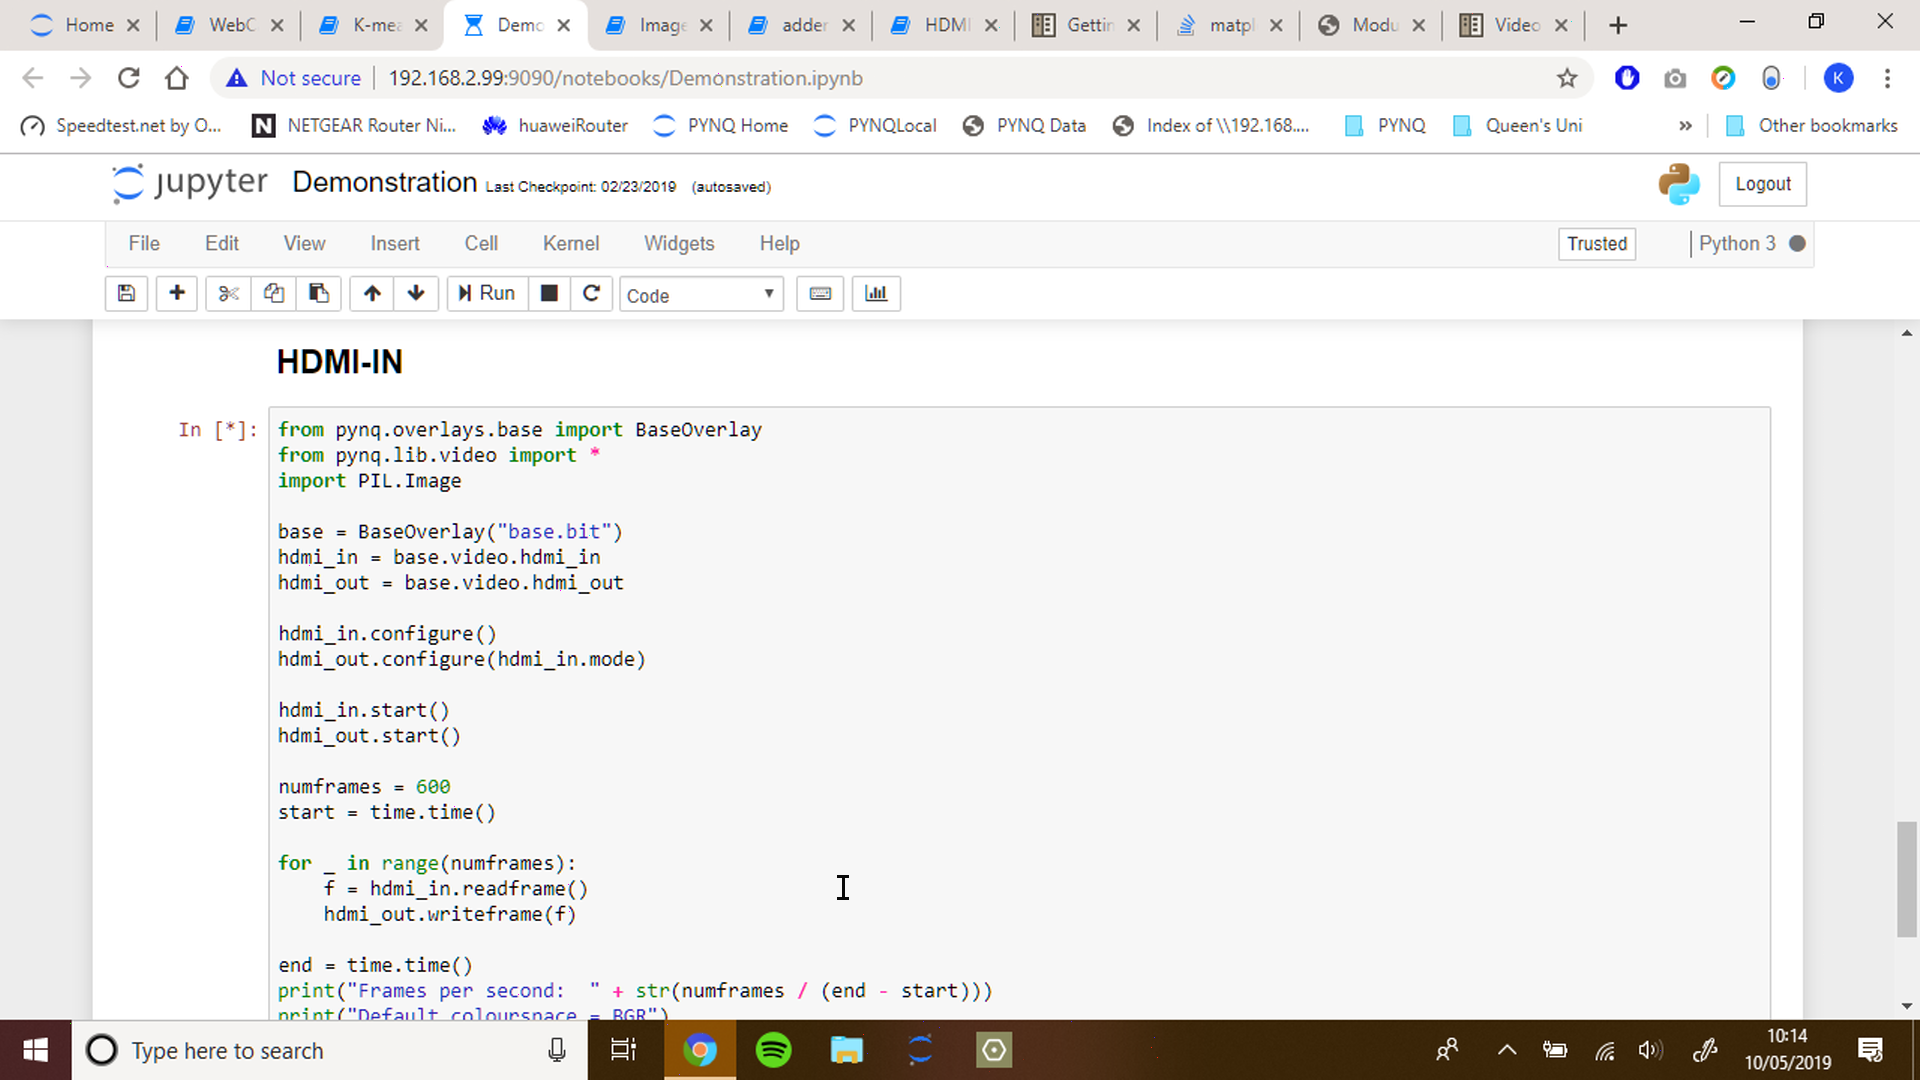

In [21]:
from pynq.overlays.base import BaseOverlay
from pynq.lib.video import *
import PIL.Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import Image

base = BaseOverlay("base.bit")
hdmi_in = base.video.hdmi_in
hdmi_out = base.video.hdmi_out

hdmi_in.configure()
hdmi_out.configure(hdmi_in.mode)

hdmi_in.start()
hdmi_out.start()

numframes = 600
start = time.time()

for _ in range(numframes):
    f = hdmi_in.readframe()
    hdmi_out.writeframe(f)
    
end = time.time()
print("Frames per second:  " + str(numframes / (end - start)))
print("Default colourspace = BGR")

image = PIL.Image.fromarray(f)
image

In [22]:
hdmi_out.close()
hdmi_in.close()

# Webcam feed with applied K-Means

### Reduced k-means iteration criteria resulting in decreased accuracy with improved speed

Start...
Capture device is open: True


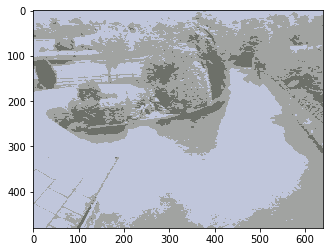

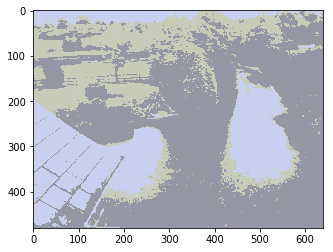

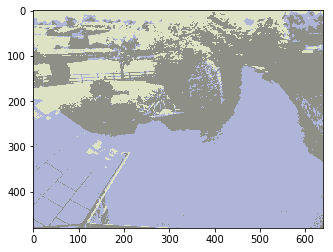

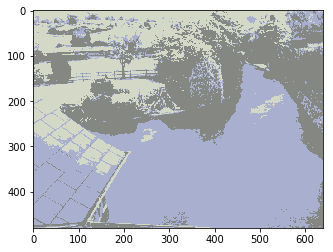

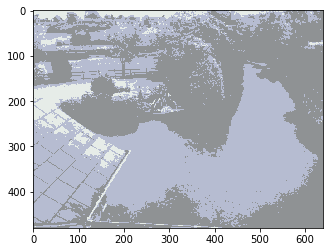

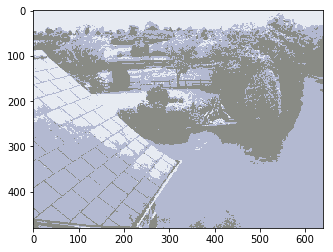

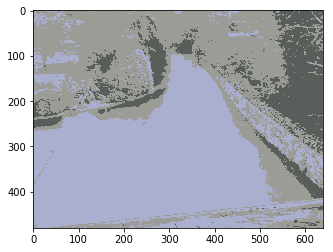

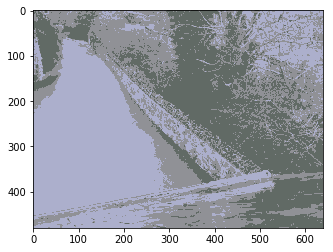

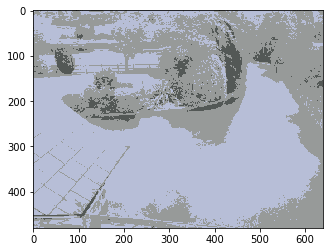

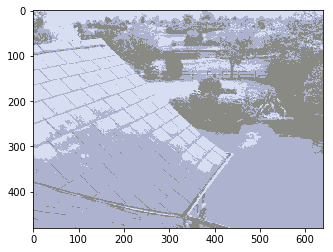

Frames per second: 0.5392065996983927
Number of read errors: 0
Standard Processing time: ~4.2 FPS


In [33]:
#Potential improvements, resize frames prior to analysis
print("Start...")
import cv2
import time
#from PIL import Image
#from resizeimage import resizeimage
from matplotlib import pyplot as plt
import numpy as np

from pynq.overlays.base import BaseOverlay
from pynq.lib.video import *
base = BaseOverlay("base.bit")

# monitor configuration: 640*480 @ 60Hz
Mode = VideoMode(640,480,24) #(640,480,24)
hdmi_out = base.video.hdmi_out
hdmi_out.configure(Mode,PIXEL_BGR)
hdmi_out.start()

# monitor (output) frame buffer size (1920x1080)
frame_out_w = 1920
frame_out_h = 1080
# camera (input) configuration
frame_in_w = 640 #640
frame_in_h = 480 #480

videoIn = cv2.VideoCapture(0)
videoIn.set(cv2.CAP_PROP_FRAME_WIDTH, frame_in_w);
videoIn.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_in_h);
print("Capture device is open: " + str(videoIn.isOpened()))

# Capture webcam image
#ret, frame_vga = videoIn.read()

num_frames = 10
readError = 0

start = time.time()
#while(1):
for i in range (num_frames):
    # read next image
    ret, frame_vga = videoIn.read()
    if (ret):
        outframe = hdmi_out.newframe()
        #cv2.cvtColor(frame_vga, cv2.COLOR_BGR2RGB) 
        Z = frame_vga.reshape((-1,3))     # # reshape the image(numPy Array) to be a list of pixels
        Z = np.float32(Z)

        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,1, 1.0)
        K=3
        ret, label1, center1 = cv2.kmeans(Z, K, None,criteria, 1, cv2.KMEANS_PP_CENTERS)
        center1 = np.uint8(center1)
        res1 = center1[label1.flatten()]
        frame_vga = res1.reshape((frame_vga.shape))

        #outframe[0:480,0:640,:] = frame_vga[0:480,0:640,:]
        outframe[:] = frame_vga
        hdmi_out.writeframe(outframe)
        
        #ret, frame_in = videoIn.read()
        %matplotlib inline 
        from matplotlib import pyplot as plt
        import numpy as np
        plt.imshow(outframe[:,:,[2,1,0]])
        plt.show()
    else:
        readError += 1
        
end = time.time()

print("Frames per second: " + str((num_frames-readError) / (end - start)))
print("Number of read errors: " + str(readError))

print("Standard Processing time: ~4.2 FPS")

videoIn.release()
hdmi_out.stop()
del hdmi_out

# Hardware Acceleration

## Initial IP Design - Data Handling

#### AdderLoop

Nested loop testing Pynq overlay design with interger addition
This IP was developed using HLS and adds two 32-bit integers together.

C code:

void adderLoop(int a, int b, int& c){
#pragma HLS INTERFACE ap_ctrl_none port=return
#pragma HLS INTERFACE s_axilite port=a
#pragma HLS INTERFACE s_axilite port=b
#pragma HLS INTERFACE s_axilite port=c

    for(int i=0;i<a;i++){
    	b++;
    }
    c = b;


In [26]:
from pynq import Overlay
import time

overlay = Overlay('/home/xilinx/pynq/overlays/adderLoop/adderLoop.bit')
addLoop = overlay.adderLoop

numframes = 600
intLoop = 100
b = 0
start = time.time()
for _ in range(numframes):
    addLoop.write(0x10, intLoop)   #write val 5 to 'a'
    addLoop.write(0x18, b)   #write val 5 to 'b'

    addLoop.read(0x20) #read val from 'c'
    
end = time.time()

print("Iterations per second:  " + str(numframes / (end - start)))
addLoop.read(0x20) #read val from 'c'


/usr/local/lib/python3.6/dist-packages/pynq/overlay.py:299: UserWarning: Users will not get PARAMETERS / REGISTERS information through TCL files. HWH file is recommended.
  warnings.warn(message, UserWarning)


Iterations per second:  11048.933339772662


100

In [27]:
b = 0
c = 0

start = time.time()

for _ in range(numframes):
    b = 0
    for _ in range(intLoop):
        b+=1
    c = b
    
end = time.time()

print("Iterations per second:  " + str(numframes / (end - start)))
print("C = " , c)

Iterations per second:  8652.36079833594
C =  100


### Average Speedup = 27.69%

# Image Streaming IP Block

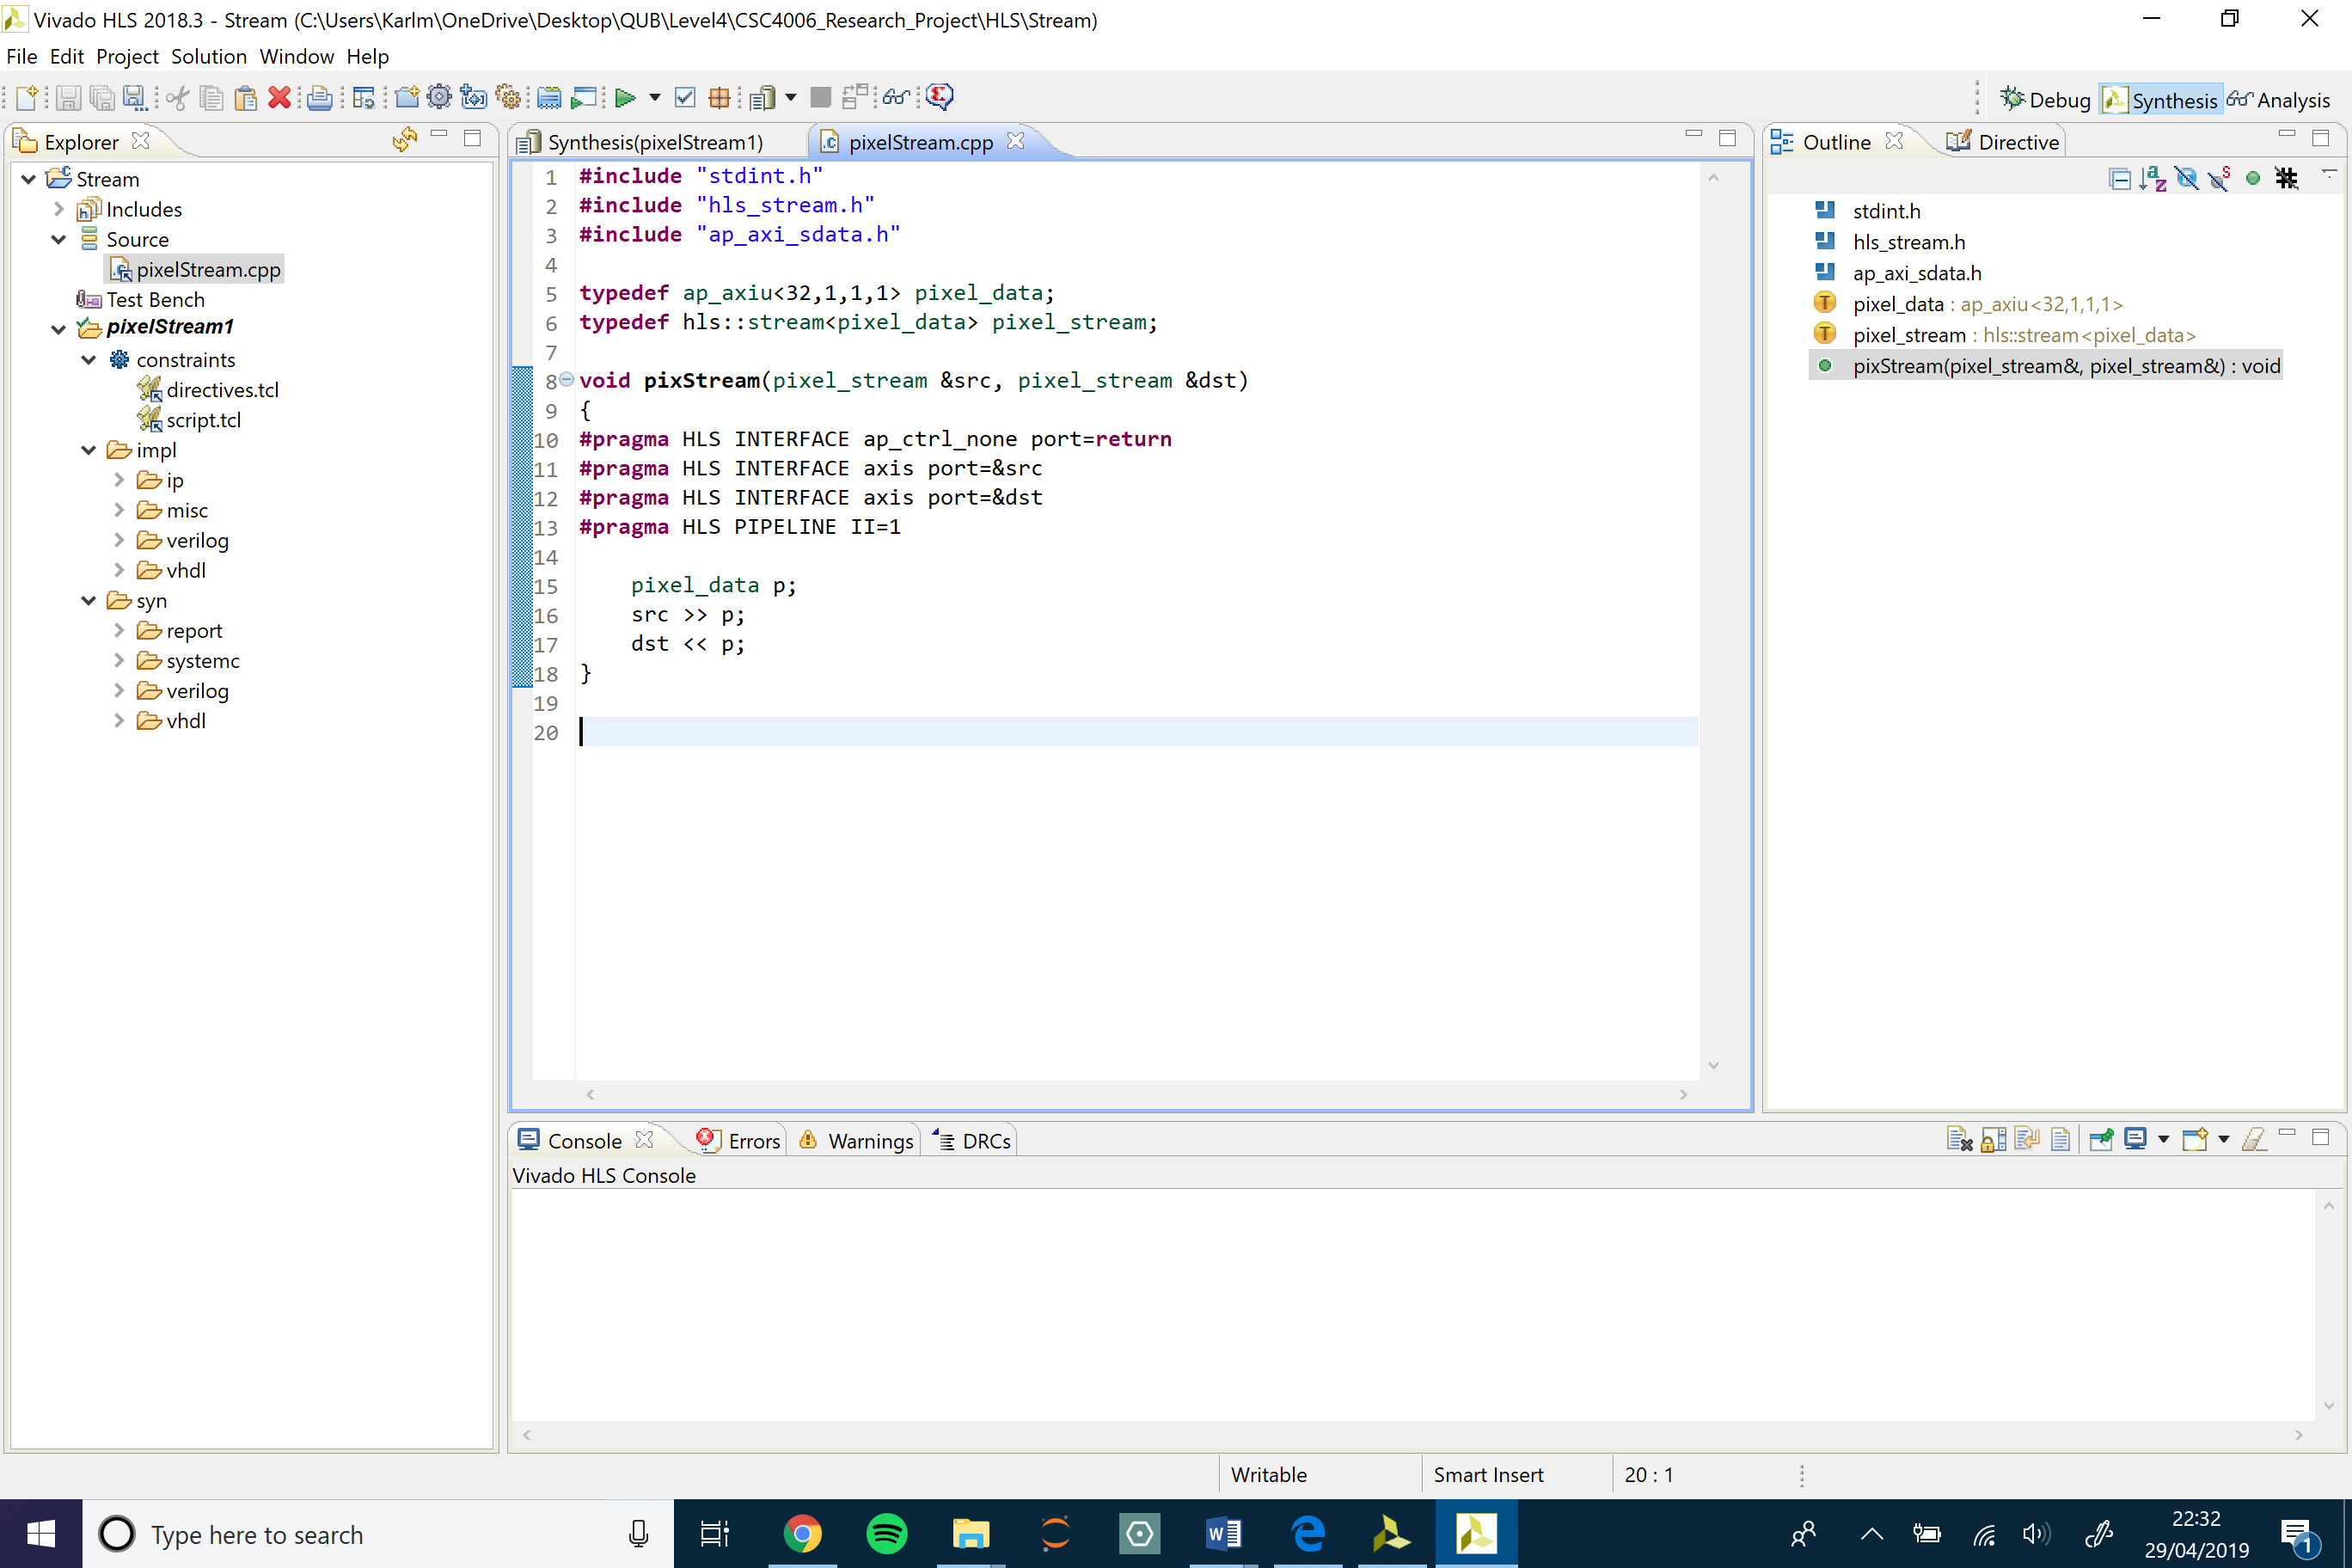

In [34]:
from IPython.display import Image
Image("img/stream.png")

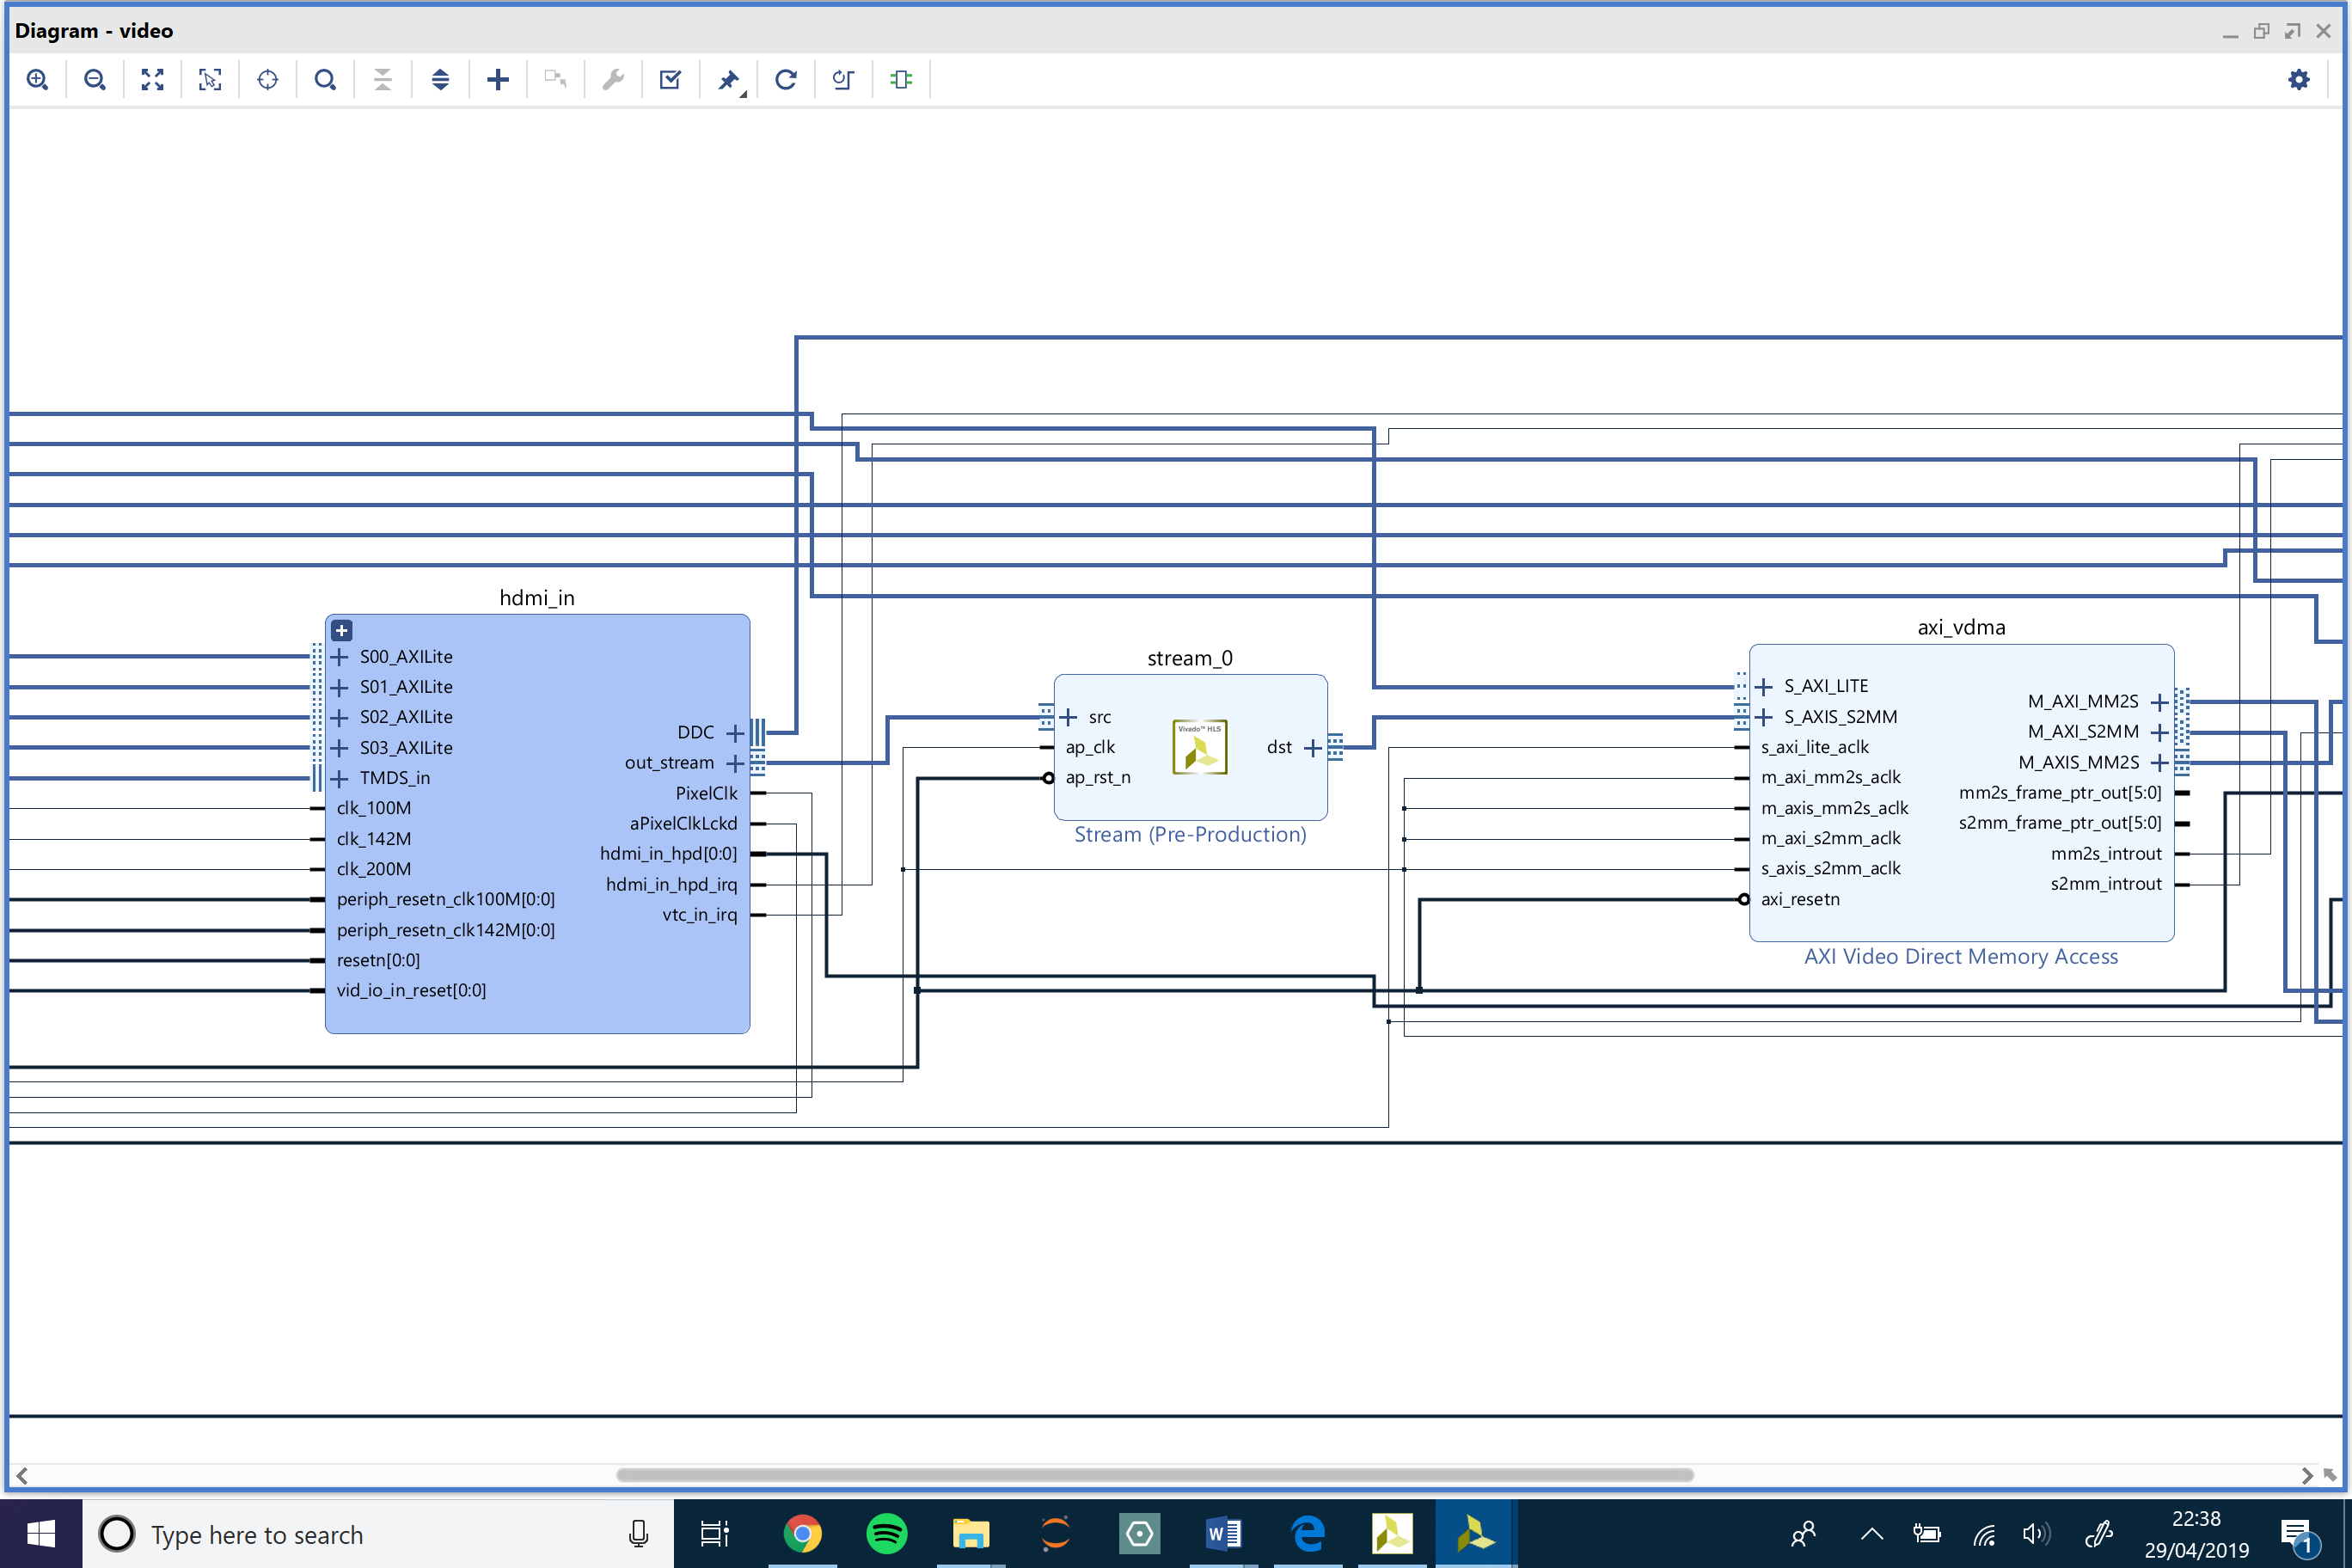

In [35]:
from IPython.display import Image
Image("img/streamLayout.png")